In [ ]:
# dependencje jeśli potrzebne
!pip install pulp
!pip install matplotlib

In [2]:
# import bibliotek
import random
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus, LpAffineExpression
from typing import Tuple, List

### Wczytywanie danych
Numeracja wariantów jak w pliku 0-26. Jednynie przy definicji problemu programowania liniowego numeracja 1-27, jak w pracy z której są.

In [3]:
# wczytane wartości kryteriów z pliku
data_file = "Nuclear waste management.csv"
data = []

with open(data_file, "r") as f:
    f.readline() # pomiń nagłówek
    for line in f:
        nr, c1, c2, c3, c4 = line.strip().split(",")
        data.append((int(nr) - 1, float(c1), float(c2), float(c3), float(c4)))
data[:4] + ["..."] + data[-4:]

[(0, 0.6, 0.93, 0.0, 0.73),
 (1, 0.66, 0.55, 0.45, 0.49),
 (2, 1.0, 0.45, 0.57, 0.5),
 (3, 0.48, 0.87, 0.0, 0.75),
 '...',
 (23, 0.73, 0.03, 1.0, 0.63),
 (24, 0.34, 1.0, 1.0, 1.0),
 (25, 0.71, 0.25, 0.88, 0.67),
 (26, 0.8, 0.06, 1.0, 0.67)]

#### Ranking referencyjny

##### Informacja prefernecyjna na podstawie której oceniane były warianty:
1. Pierwsza grupa: Wydajność produkcji energii elektrycznej wzrośnie w przyszłości. Dodatkowo nie
chcę brać pożyczek. -> Preferujemy F1 - większa wydajność w przyszlości, zatem więcej energii przy takiej samej ilości odpadów, bardzo nie chcemy F3 - kredyt
2. Druga grupa: W skutek wyczerpywania się złóż materiałów radioaktywnych, elektrownie mogą
zacząć korzystać z bardziej ubogich złóż, co przełoży się na zwiększenie ilości odpadów radioak-
tywnych. -> preferujemy F3, i F2 bardziej - opłata od ilości odpadów, chcemy też przechowywać krócej, żeby czasem magazyn się nie wypełnił całkowicie w przyszłośći przy większej ilości odpadów (S1>S2>S3).
3. Łącząc wyniki obu grup, preferujemy jak najkrótsze przechowywanie odpadów: S1>S2>S3. Preferencje co do planów finansowania wybierzmy z pierwszej grupy - uznajmy, że zupełnie nie chcemy kredytu, a wydajność energii wzrośnie znacząco: F1>F2>>F3. Brak informacji o preferencji lokalizacji, zatem: R1=R2=R3.

#### Ocena Wariantów
Za pomocą powyższych preferencji, oceniono kolejno 2 pary wariantów, po 1 przydzielonym do osoby oraz 3 pary wariantów wybrane losowo - generator liczb losowych 0-26.

Warianty 13, 16: 13~16, różnią się tylko lokalizacją\
Warianty 14, 25: 25>14, 14 lepszy plan przechowywania odpadów, ale znacząco gorszy plan finansowy\
Warianty 9, 7:   9~7, lepszy plan finansowy 9 jest niwelowany przez plan krótszego przechowywania odpadów 7\
Warianty 11, 18: 18>11, o wiele lepszy plan finansowania\
Warianty 23, 6:  6>23, 6 to właściwie wariant idealny

Mamy zatem 2 pary wariantów nierozróżnialnych i 3 pary wariantów w których jeden jest preferowany nad drugi.

In [4]:
# definicja preferencji i parametrów metody dla konkretnego przykładu
indiff_variants = [(13, 16), (9, 7)] # (x, y) -> x~y, nierozróżnialne
pref_variants = [(25, 14), (18, 11), (6, 23)] # (x, y) -> x>y, preferencje
criterion_directions = ["cost", "gain", "gain", "cost"]
# od 0 do 1 bo wiemy, że dane są znormalizowane do przedziału [0, 1]
min_values = [0, 0, 0, 0] # minimalne wartości kryteriów
max_values = [1, 1, 1, 1] # maksymalne wartości kryteriów
number_breaks = [2, 3, 1, 0] # liczba punktów przełamania dla funkcji liniowej dla każdego kryterium
eps = 0.01 # mała liczba do ograniczeń nierozróżnialności, o tyle mogą się różnić użyteczności wariantów by stwierdzenie x~y było prawdziwe

In [5]:
criterions = ["C1", "C2", "C3", "C4"]
number_breakpoints = [x + 2 for x in number_breaks] # to co wyżej plus minimum i maksimum
diffs = [max_val - min_val for min_val, max_val in zip(min_values, max_values)] # różnice między wartościami maksymalnymi i minimalnymi dla każdego kryterium
breakpoints = []

for j, nb in enumerate(number_breakpoints):
    bp = []
    for i in range(nb):
        bp.append(min_values[j] + i * diffs[j] / (nb - 1)) # punkty przełamania dla funkcji liniowej na kryterium j
    breakpoints.append(tuple(bp))

# breakpoints

In [6]:
def add_monotonicity_constraints(prob: LpProblem) -> Tuple[LpProblem, List[List[LpVariable]], List[LpVariable], List[LpVariable]]:
    u_a = [] # zmienne u_i(a_i), gdzie a_i to najgorsza wartość kryterium i
    u_b = [] # zmienne u_i(b_i), gdzie b_i to najlepsza wartość kryterium i
    u_breakpoints = [] # macierz ixj zmienne u_i(x_i^j), gdzie x_i^j to j-ty punkt przełamania dla kryterium i

    # ograniczenia monotoniczności
    for i, dir in enumerate(criterion_directions):
        u_bp = []
        for j, bp in enumerate(breakpoints[i]):
            u_bp.append(LpVariable(name=f"u_{i+1}({bp})", lowBound=0, upBound=1)) # zmienne u_i(x_i^j) wyrażające użyteczność dla każdego kryterium i punktu przełamania
        
        # dodanie ograniczeń monotoniczności
        if dir == "gain":
            for j in range(len(u_bp) - 1):
                # im większa wartość na kryterium tym większa użyteczność
                prob += u_bp[j] <= u_bp[j + 1], f"Monotonicity_{criterions[i]}_{j}"
            u_a.append(u_bp[0])
            u_b.append(u_bp[-1])
        else:
            for j in range(len(u_bp) - 1):
                # im większa wartość na kryterium tym mniejsza użyteczność
                prob += u_bp[j] >= u_bp[j + 1], f"Monotonicity_{criterions[i]}_{j}"
            u_a.append(u_bp[-1])
            u_b.append(u_bp[0])
        u_breakpoints.append(u_bp)
    return prob, u_breakpoints, u_a, u_b

In [7]:
def add_normalization_constraints(prob: LpProblem, u_a: List[LpVariable], u_b: List[LpVariable]) -> LpProblem:
    # suma nalepszych wartości użyteczności = 1
    prob += lpSum(u_b) == 1, "Sum_of_u_b=1"
    # najgorsze użyteczności = 0
    for i, ua in enumerate(u_a):
        prob += ua == 0, f"u_a_{i+1}=0"
    return prob

In [8]:
def calculate_variant_utility(nr: int, u_breakpoints: List[List[LpVariable]]) -> LpAffineExpression:
    local_utilities = []
    for i, bp in enumerate(breakpoints):
        u_bp = u_breakpoints[i] # zmienne użyteczności dla punktów przłamania (breakpoints) na kryterium i
        diff = diffs[i] / (number_breakpoints[i] - 1) # różnica wartości kryterium między punktami kolejnymi przegięcia
        val_c = data[nr][i + 1] # wartość kryterium i dla wariantu nr
        
        for j in range(len(bp) - 1):
            if val_c < bp[j + 1]:
                break
        # (j, j+1) - numery punktów przegięcia między którymi należy obliczyć interpolację
        start = j
        end = j + 1
        # użyteczność na kryterium to użyteczność w początkowym punkcie przegięcia + interpolacja liniowa między punktami przegięcia
        local_utilities.append(u_bp[start] + (val_c - bp[start]) * (u_bp[end] - u_bp[start]) / diff)
    return lpSum(local_utilities) # globalna użyteczność wariantu to suma lokalnych użyteczności


In [9]:
# po to by wygodnie mieć dostęp do zmiennych globalnych użyteczności wariantów
def vars_global_utilities(prob: LpProblem, u_breakpoints: List[List[LpVariable]]) -> List[LpVariable]:
    global_utilities = []
    # dla każdego wariantu dodajemy zmienną globalnej użyteczności
    # oraz ograniczenie wyrażające ją jako sumę lokalnych użyteczności
    for i in range(len(data)):
        global_utilities.append(LpVariable(name=f"U_x{i+1}")) # ograniczenia na przedział [0, 1] niepotrzebne, bo wymuszone przez inne ograniczenia
        prob += global_utilities[i] == calculate_variant_utility(i, u_breakpoints), f"Global_utility_x{i+1}"
    return prob, global_utilities

## UTA

In [12]:
prob = LpProblem("UTA", LpMaximize)
epsilon = LpVariable("epsilon", lowBound=None, upBound=None) # maksymalizowana zmienna

u_a = None # tablica zmiennych u_i(a_i), gdzie a_i to najgorsza wartość kryterium i
u_b = None # tablica zmiennych u_i(b_i), gdzie b_i to najlepsza wartość kryterium i
u_breakpoints = None # macierz ixj zmienne u_i(x_i^j), gdzie x_i^j to j-ty punkt przełamania dla kryterium i
global_utilities = None # tablica użyteczności globalnych dla każdego wariantu

# funkcja celu
prob += epsilon, "Maximize_epsilon" # maksymalizowana zmienna epsilon + suma najgorszych użyteczności

# ograniczenia monotoniczności
prob, u_breakpoints, u_a, u_b = add_monotonicity_constraints(prob)

# ograniczenia normalizacji
prob = add_normalization_constraints(prob, u_a, u_b)

# ograniczenia wynikające z preferencji decydenta

# ograniczenia preferencji
prob, global_utilities = vars_global_utilities(prob, u_breakpoints) # zmienne globalnych użyteczności dla każdego wariantu
for i, (x, y) in enumerate(pref_variants):
    prob += global_utilities[x] >= global_utilities[y] + epsilon, f"Preference_{x+1}_over{y+1}" # x>y

# ograniczenia nierozróżnialności
for i, (x, y) in enumerate(indiff_variants):
    # nie wiem czy == zadziała dobrze z epsilonem w pulpie, więc używam po prostu 2 relacje, przynajmniej widać co się dzieje
    prob += global_utilities[x] - global_utilities[y] <= eps, f"Indifference_{x+1}_over{y+1}_1" # x~y
    prob += global_utilities[x] - global_utilities[y] >= -eps, f"Indifference_{y+1}_over{x+1}_2" # y~x

# ograniczenie wynikające z zadania
for i, ub in enumerate(u_b):
    prob += ub >= 0.01, f"u_{i+1}_b>=0.1"

# prob

In [13]:
prob.solve()

# Print results
print(f"Status: {LpStatus[prob.status]}")
# print("\nOptimal Solution:")
# for var in prob.variables():
#     print(f"{var.name} = {value(var)}")

print("\nObjective value:", value(prob.objective))

Status: Optimal

Objective value: 0.27007962


#### Wykresy

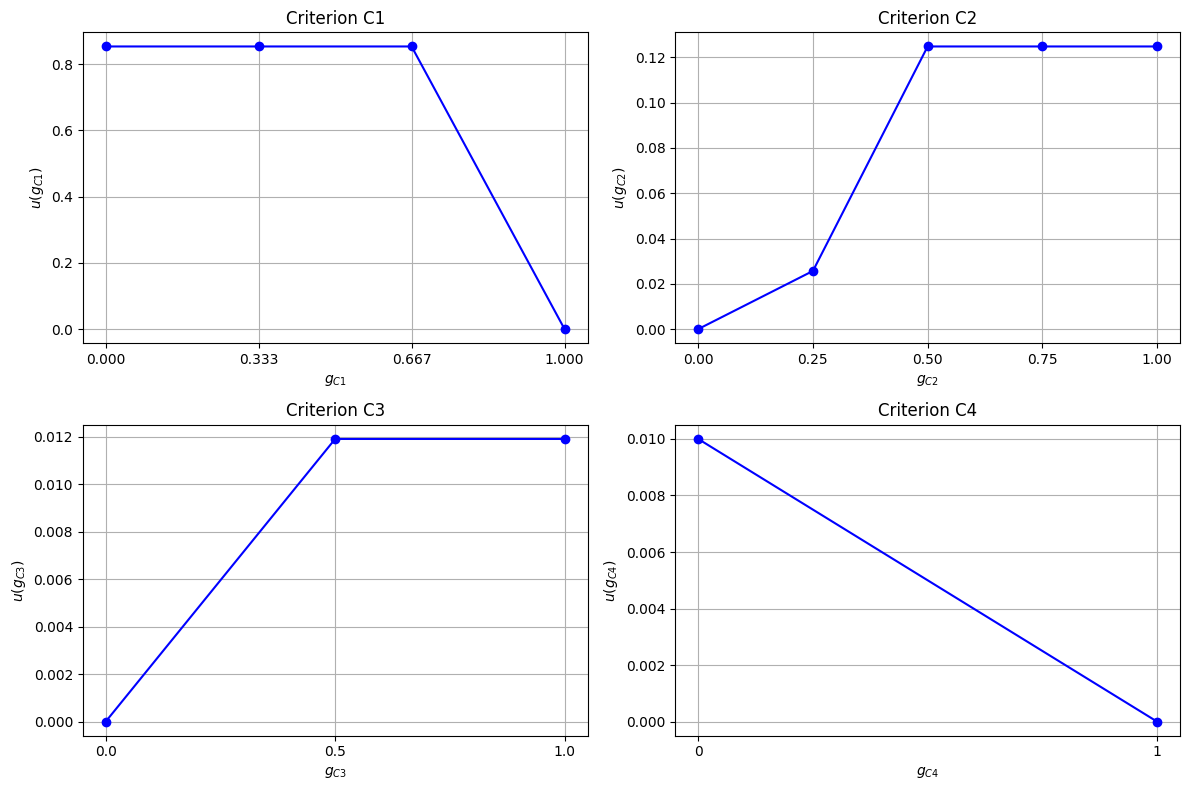

In [14]:
# wykres dla każdego kryterium
# %matplotlib inline

# po 2 wykresy na wiersz
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, u_b in enumerate(u_breakpoints):
    criterion = criterions[i]
    args = [bp for bp in breakpoints[i]]
    values = [value(u_b[j]) for j in range(len(u_b))]
    axs[i].plot(args, values, marker='o', linestyle='-', color='b', label=f"$u(g_{criterion})$")
    axs[i].set_title(f"Criterion {criterions[i]}")
    axs[i].set_xlabel(f"$g_{{{criterion}}}$")
    axs[i].set_ylabel(f"$u(g_{{{criterion}}})$")
    axs[i].set_xticks(args)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## UTAGMS